In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
data = data[[0,5]]
data.columns = ["sentiment", "text"]

data["sentiment"] = data["sentiment"].replace(4, 1)

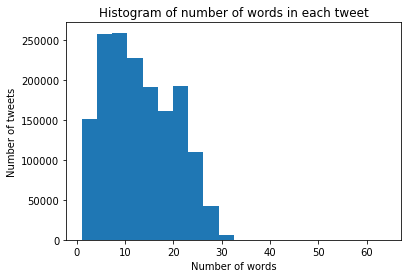

In [3]:
# Calculating number of words in each tweet:
data["word_count"] = data["text"].apply(lambda x: len(x.split()))
# plot histogram of number of words:
plt.hist(data["word_count"], bins=20)
plt.title("Histogram of number of words in each tweet")
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
data.drop("word_count", axis=1, inplace=True)

Due to twitter forcably limiting the number of characters, the number of words in each tweet are fairly constrained to under 30 words per tweet. For this reason we find it appropriate to use 30 word fixed length sequcnes for our models.

In [4]:
data.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

## Metrics
#### Accuracy:

Because the dataset is balanced, accuracy is an appropriate metric to use on our dataset. Our models will potentially be used to measure sentiment regarding certain topics on twitter and accuracy is a good measure to gauge the classification performance for that task.


## Splitting:

We will use a stratified train test split. We have enough data, 1.6M tweets split amoung two classes is enough data to train and test with. 

In [5]:
from sklearn.model_selection import train_test_split